In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
import copy
from pprint import pprint

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

import gensim
from gensim.models import *
from gensim.models.fasttext import FastText
from gensim.utils import simple_preprocess
import gensim.corpora as corpora


from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import *

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_with_sentiment_v2.csv')
tweets_neg_df = tweets_df[tweets_df['sentiment_flair']==-1]
tweets_neg_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk,sentiment_flair_glove_embed_kmeans,sentiment_fast_text_embed_kmeans,sentiment_fast_text_embed_nmf_kmeans
0,0,very bad thing say that government did not med...,Mumbai,2022,"['very', 'bad', 'thing', 'say', 'that', 'gover...",-1,-1,-1,-1,1
1,1,all netas and their family should admitted onl...,Mumbai,2022,"['all', 'netas', 'and', 'their', 'family', 'sh...",-1,-1,-1,-1,1
5,5,very hygiene government veterinary hospital as...,Mumbai,2022,"['very', 'hygiene', 'government', 'veterinary'...",-1,1,-1,-1,-1
7,7,shall throw out india let take care our health...,Mumbai,2022,"['shall', 'throw', 'out', 'india', 'let', 'tak...",-1,1,-1,-1,1
9,9,not online school wild guess going south mumba...,Mumbai,2022,"['not', 'online', 'school', 'wild', 'guess', '...",-1,-1,-1,1,-1


In [3]:
tfidf = TfidfVectorizer(lowercase=False)
x_tfidf = tfidf.fit_transform(tweets_neg_df['tweet'])
x_tfidf_numpy = x_tfidf.toarray()

In [4]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = tweets_neg_df['tweet'].values.tolist()
data_words = list(sent_to_words(data))

In [5]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
import spacy
spacy.load('en_core_web_sm')

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [8]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [9]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"understand" + 0.070*"mean" + 0.060*"hospital" + 0.039*"doctor" + '
  '0.012*"government" + 0.010*"patient" + 0.007*"poor" + 0.007*"get" + '
  '0.007*"private" + 0.007*"significant"'),
 (1,
  '0.067*"hospital" + 0.028*"poor" + 0.027*"doctor" + 0.021*"people" + '
  '0.019*"get" + 0.014*"treatment" + 0.013*"patient" + 0.013*"money" + '
  '0.013*"pay" + 0.011*"government"'),
 (2,
  '0.070*"hospital" + 0.020*"terminal" + 0.016*"patient" + 0.016*"doctor" + '
  '0.013*"dead" + 0.012*"take" + 0.009*"death" + 0.009*"report" + '
  '0.007*"condition" + 0.007*"injure"'),
 (3,
  '0.047*"take" + 0.046*"road" + 0.042*"action" + 0.033*"hospital" + '
  '0.016*"ambulance" + 0.013*"traffic" + 0.013*"parking" + 0.012*"police" + '
  '0.011*"vehicle" + 0.010*"park"'),
 (4,
  '0.043*"doctor" + 0.034*"hospital" + 0.014*"service" + 0.012*"bad" + '
  '0.008*"call" + 0.007*"go" + 0.007*"come" + 0.007*"give" + 0.007*"terminal" '
  '+ 0.007*"staff"'),
 (5,
  '0.087*"guess" + 0.067*"wild" + 0.046*"ho

In [10]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.39736740179468305


In [11]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [15]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    for i in range(len(corpus_sets)):
        for k in topics_range:
            cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                            k=k, a=0.01, b=0.01)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Alpha'].append(0.01)
            model_results['Beta'].append(0.01)
            model_results['Coherence'].append(cv)
            
            pbar.update(1)
    pd.DataFrame(model_results).to_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/lda_tuning_results.csv', index=False)
    pbar.close()

  6%|▋         | 16/256 [07:48<1:57:04, 29.27s/it]


<Axes: xlabel='Topics', ylabel='Coherence'>

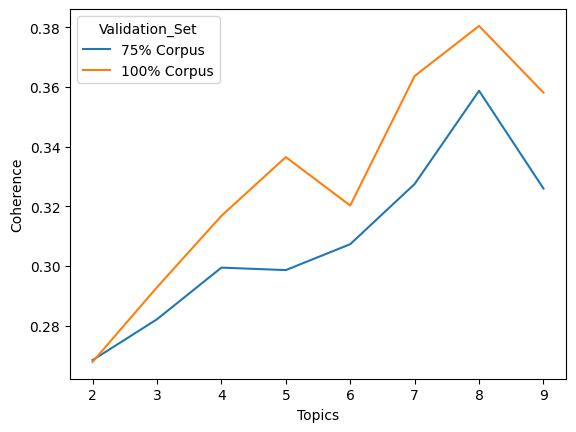

In [17]:
lda_results = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/lda_tuning_results.csv')
sns.lineplot(x='Topics', y='Coherence', hue='Validation_Set', data=lda_results)

In [18]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [21]:
import pyLDAvis.gensim_models as gensimvis
import os
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.252996  0.011148       1        1  75.123940
5      0.023978 -0.074742       2        1   8.517947
4     -0.021211  0.073911       3        1   5.769353
7     -0.013618 -0.054782       4        1   5.678310
1      0.003141  0.040388       5        1   4.068009
6     -0.081754  0.001439       6        1   0.332157
2     -0.081841  0.001287       7        1   0.319488
3     -0.081691  0.001351       8        1   0.190796, topic_info=           Term         Freq        Total Category  logprob  loglift
58        guess  1077.000000  1077.000000  Default  30.0000  30.0000
65         wild   795.000000   795.000000  Default  29.0000  29.0000
20     hospital  7763.000000  7763.000000  Default  28.0000  28.0000
214        help   547.000000   547.000000  Default  27.0000  27.0000
55        death   622.000000   622.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
8374     fodder     0.066587     3.343268   Topic8  -8.4462   2.3455
10324     dairy     0.066744     3.406073   Topic8  -8.4438   2.3293
1656        set     0.107727    47.408706   Topic8  -7.9651   0.1748
5892    element     0.066003     9.129555   Topic8  -8.4550   1.3321
2703    reverse     0.064498     4.746847   Topic8  -8.4780   1.9631

[474 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
785       1  0.035485   accident
785       2  0.550024   accident
785       3  0.088714   accident
785       4  0.088714   accident
785       5  0.248398   accident
...     ...       ...        ...
2232      4  0.009685  yesterday
2232      5  0.019370  yesterday
6063      1  0.228705      zakir
6063      2  0.228705      zakir
6063      4  0.457409      zakir

[1290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 8, 2, 7, 3, 4])